In [2]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import VotingRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn import ensemble
from sklearn import svm
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier

import optuna

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = pd.read_csv('data.csv')

# Pisahkan data setelah klasifikasi, yang bukan 187
data = data[data['Cholesterol Total (mg/dL)'] != 187]

# encoding Jenis Kelamin if M = 1 and F = 0
data["Jenis Kelamin"] = data["Jenis Kelamin"].apply(lambda x: 1 if x == 'M' else 0)

# drop Tempat lahir
data.drop(['Tempat lahir', 'Responden'], axis=1, inplace=True)

# Target yang ingin diprediksi
target = data['Cholesterol Total (mg/dL)']

ori_col = data.columns

In [4]:
count = target.value_counts()
print(count)

Cholesterol Total (mg/dL)
174.0    14
180.0    12
203.0    11
206.0    11
198.0    10
         ..
251.0     1
127.0     1
146.0     1
308.0     1
249.0     1
Name: count, Length: 143, dtype: int64


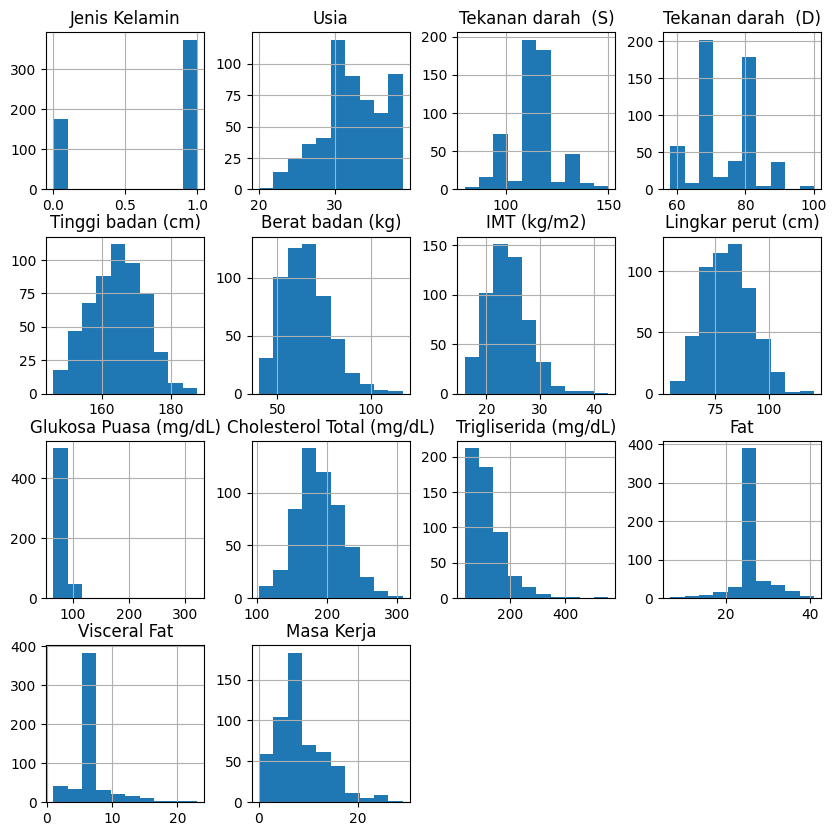

In [5]:
import matplotlib.pyplot as plt

data.hist(figsize=(10, 10))
plt.show()

<Axes: >

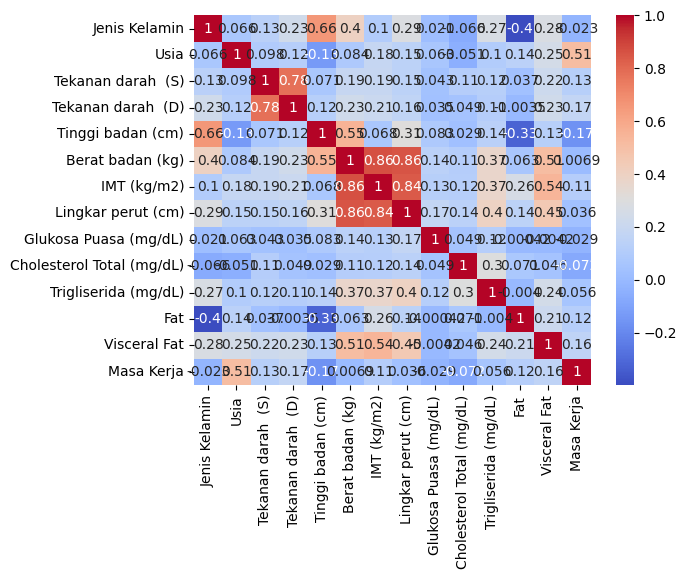

In [6]:
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = data.corr()

# Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')


In [7]:
def plotter(data, target):
    from math import ceil
    fig, ax = plt.subplots(ceil(len(data.columns)/5), 5, figsize = (35, 20))
    ax = ax.flatten()

    # Iterate over the columns
    for i, column in enumerate(data.columns):
        ax[i].set_title(f'{target} vs {column}')
        ax[i].scatter(data[target], data[column])


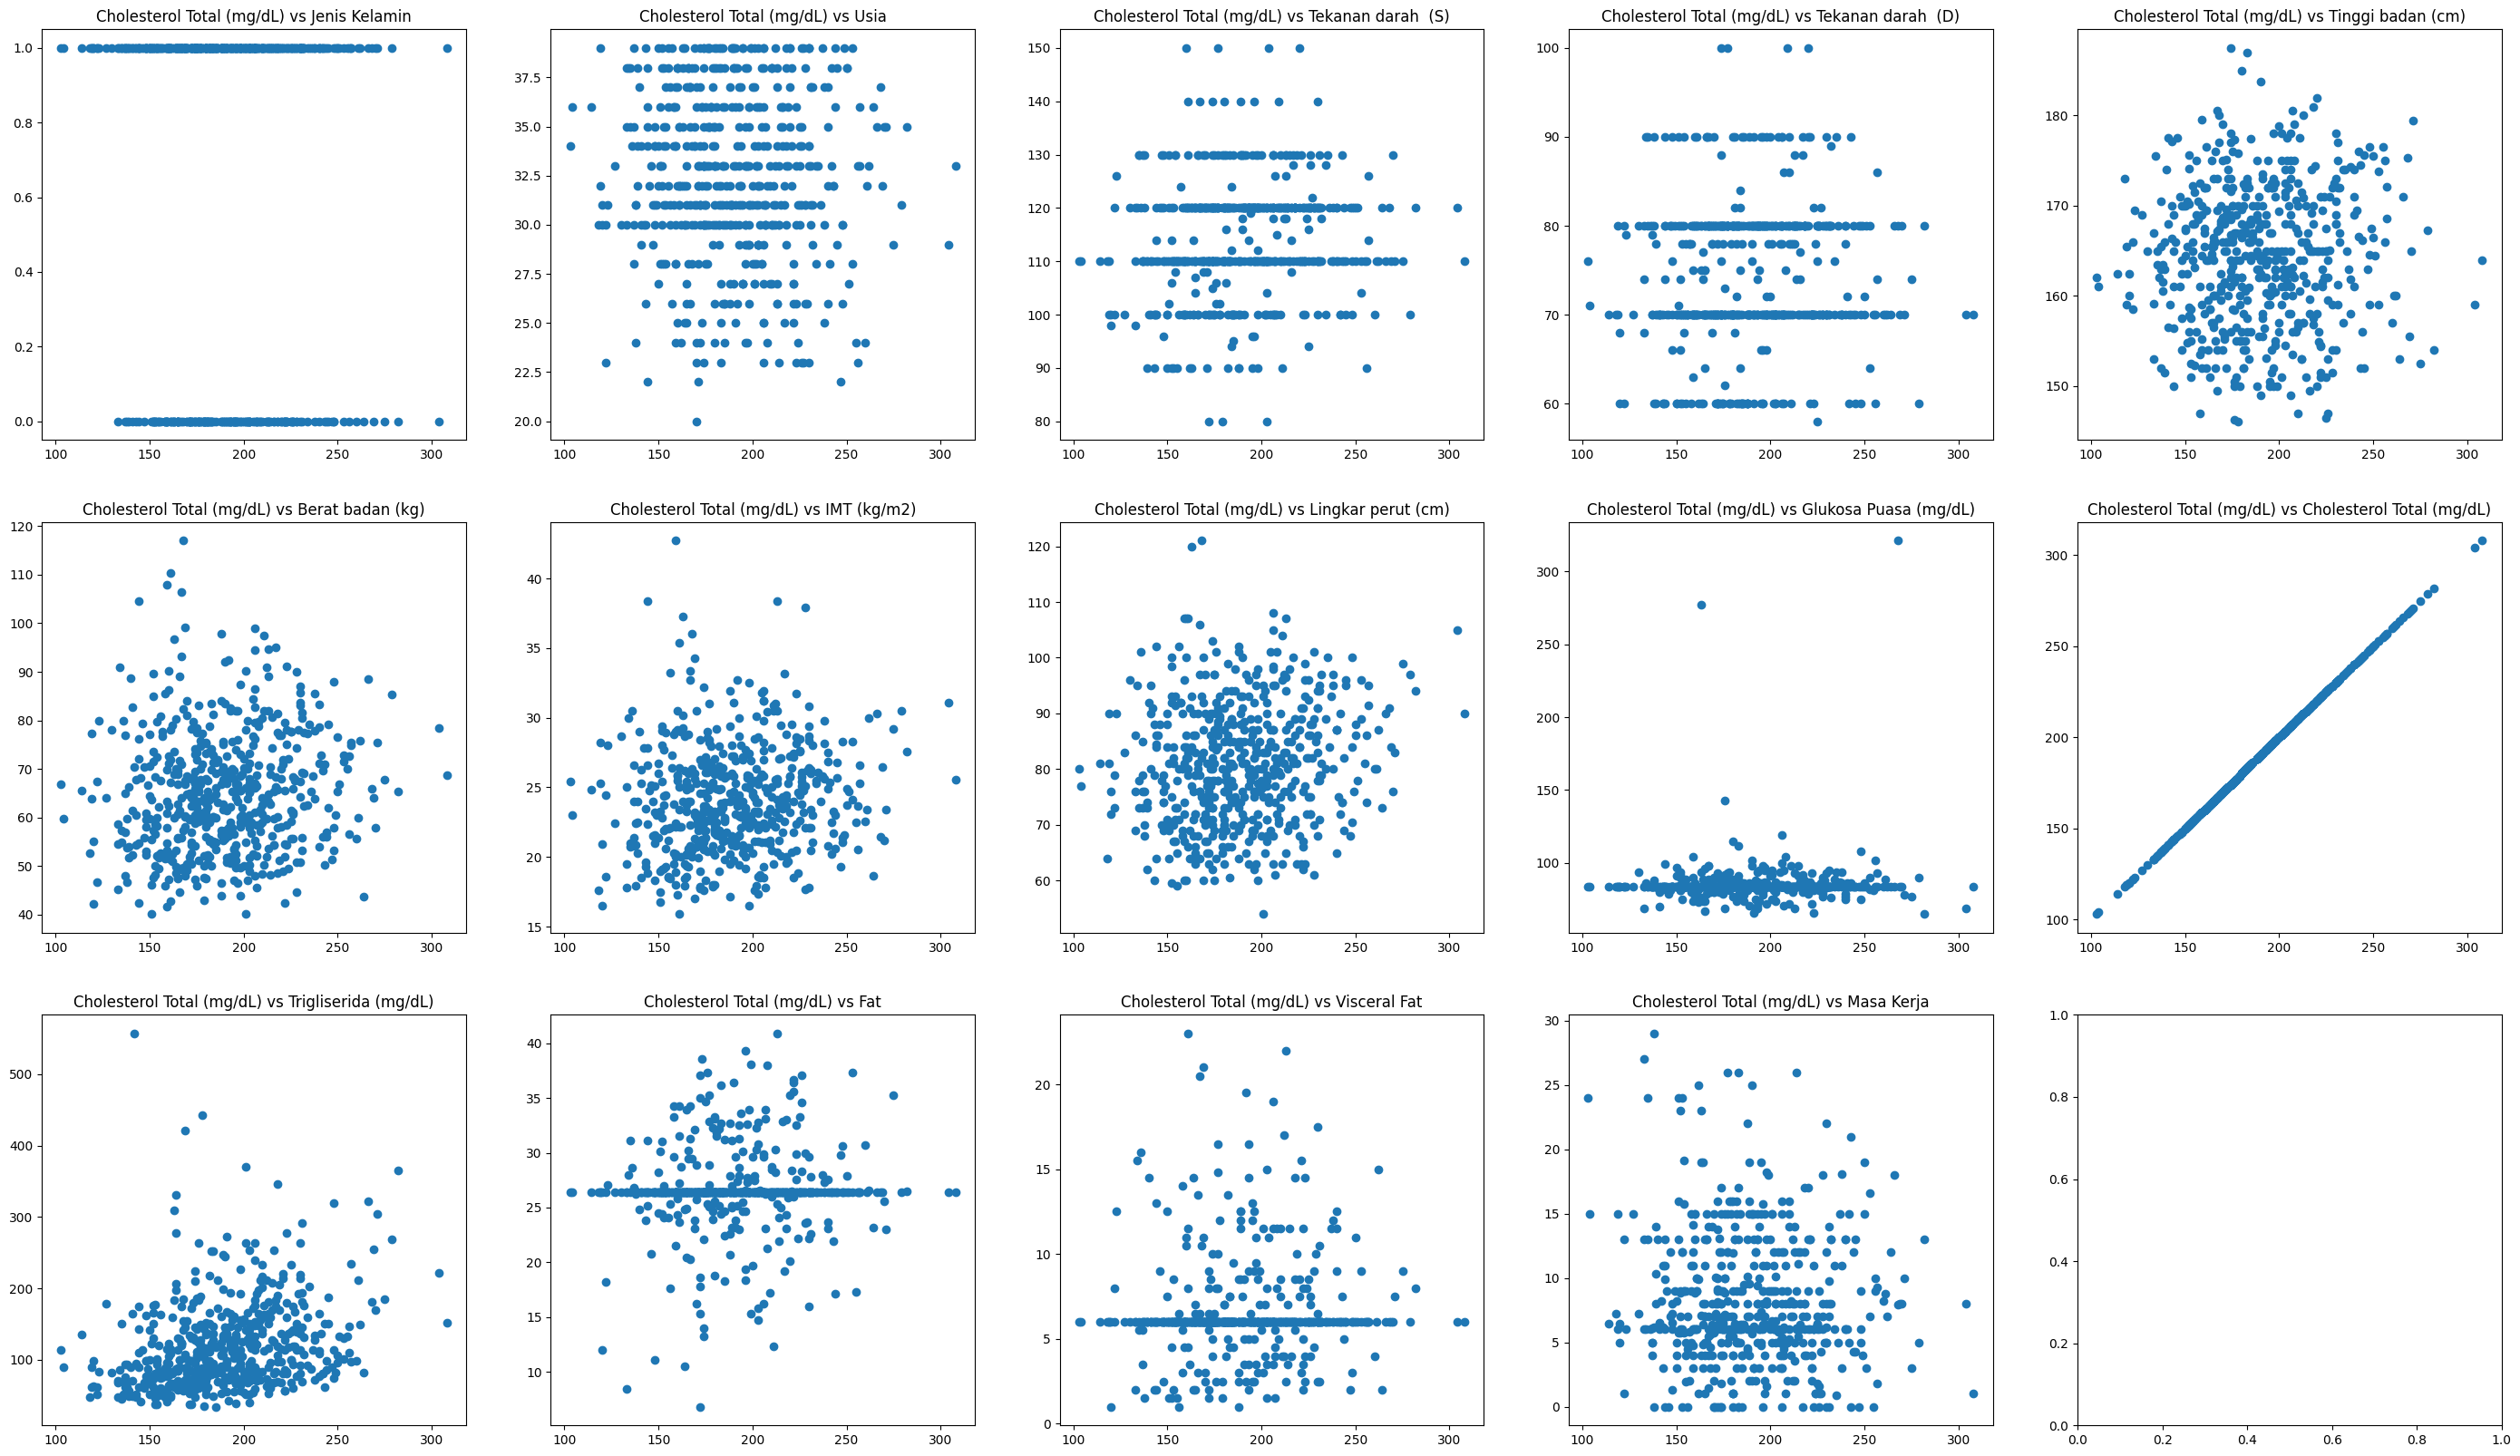

In [8]:
plotter(data, 'Cholesterol Total (mg/dL)')

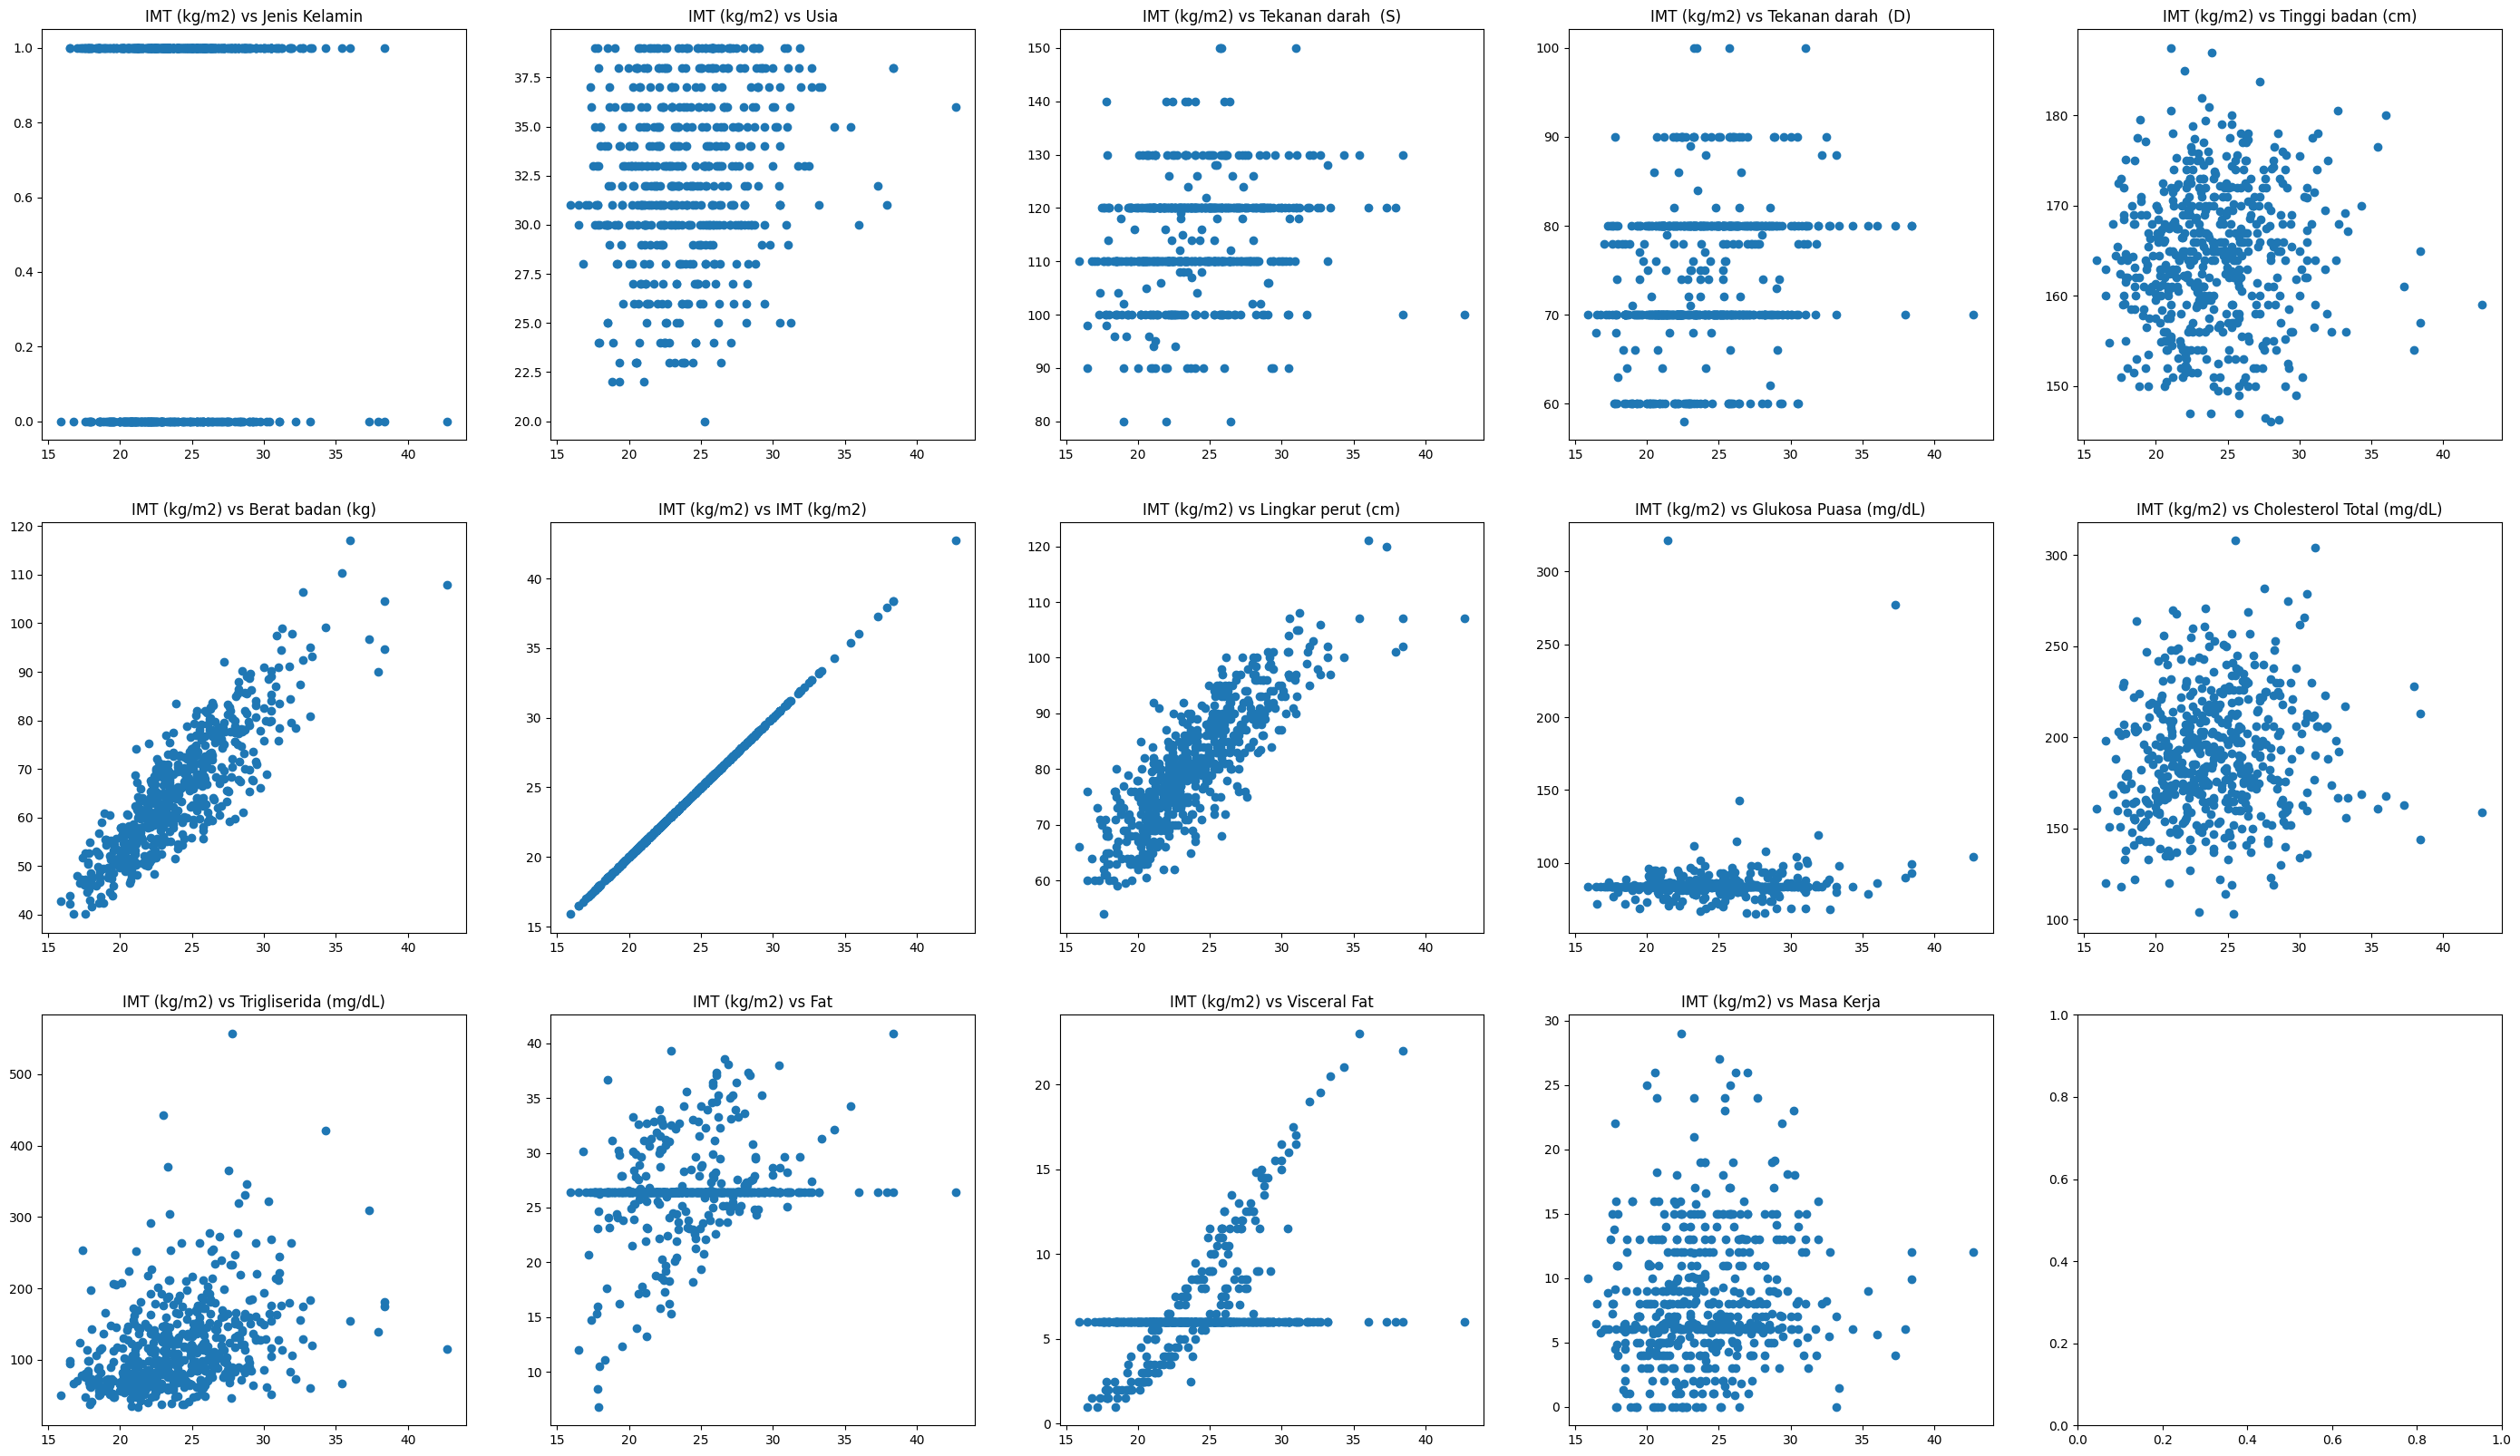

In [9]:
plotter(data, 'IMT (kg/m2)')

In [10]:
data['Visceral Fat'].unique()

array([ 6. ,  2. ,  4. ,  2.5,  3.5,  8. ,  9.5,  1.5,  7. , 12. ,  5. ,
        4.5, 10. ,  3. ,  9. , 12.5, 11.5,  7.5,  8.5, 13.5,  5.5, 10.5,
        1. ,  6.5, 11. , 15. , 13. , 16. , 14.8, 23. , 14.5, 21. , 16.5,
       14. , 20.5, 15.5, 19.5, 22. , 17.5, 19. , 17. ])

In [11]:
count = data['Visceral Fat'].value_counts()
print(count[:5])

count = data['Fat'].value_counts()
print(count)

Visceral Fat
6.0     354
2.5      12
2.0      11
4.0      10
8.0      10
8.5      10
11.5     10
9.0       9
3.5       9
7.5       9
1.5       8
5.0       8
Name: count, dtype: int64
Fat
26.4    339
25.2      5
27.9      5
29.6      5
23.1      4
       ... 
18.8      1
25.5      1
26.8      1
34.6      1
17.1      1
Name: count, Length: 132, dtype: int64


In [12]:
def correct_with_regression(col, val):
    correct_data = data[data[col] != val][['IMT (kg/m2)', col]]
    x, y = correct_data[['IMT (kg/m2)']], correct_data[[col]]
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(data[['IMT (kg/m2)']])
    ret_pred = []

    def rounder(x, col):
        best = 10**9
        for elm in data[col].unique():
            if abs(elm-x) < abs(best-x):
                best = elm
        return best

    check = data[['IMT (kg/m2)', col]]
    for idx in range(len(check)):
        if check.iloc[idx,1] == val:
            ret_pred.append(rounder(y_pred[idx], col))
        else:
            ret_pred.append(check.iloc[idx,1])
    
    return np.array(ret_pred)

In [13]:
data['Correct Fat'] = correct_with_regression('Fat', 26.4)
data['Correct Visceral'] = correct_with_regression('Visceral Fat', 6)

In [14]:
data['Calculated IMT'] = 10000*data['Berat badan (kg)']/(data['Tinggi badan (cm)'])**2

In [15]:
data

,Jenis Kelamin,Usia,Tekanan darah (S),Tekanan darah (D),Tinggi badan (cm),Berat badan (kg),IMT (kg/m2),Lingkar perut (cm),Glukosa Puasa (mg/dL),Cholesterol Total (mg/dL),Trigliserida (mg/dL),Fat,Visceral Fat,Masa Kerja,Correct Fat,Correct Visceral,Calculated IMT
9,1,20.0,120.0,80.0,179.0,80.95,25.26,90.0,80.0,170.0,89.0,26.4,6.0,2.00,27.6,9.0,25.264505
48,0,22.0,120.0,80.0,163.0,51.35,19.32,68.0,84.0,247.0,89.0,29.8,2.0,0.00,29.8,2.0,19.327035
52,0,22.0,90.0,70.0,155.5,50.70,21.00,65.0,84.0,171.0,53.0,26.4,6.0,0.00,24.5,4.0,20.967525
54,0,22.0,100.0,60.0,150.0,42.40,18.84,64.0,84.0,144.0,61.0,31.1,2.0,0.00,31.1,2.0,18.844444
108,0,23.0,110.0,70.0,166.0,56.60,20.54,74.0,84.0,256.0,147.0,26.4,6.0,9.00,24.3,3.5,20.539991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1334,1,39.0,110.0,70.0,162.5,67.60,25.60,87.0,84.0,169.0,72.0,23.8,11.0,6.00,23.8,11.0,25.600000
1335,0,39.0,120.0,70.0,150.0,60.50,26.90,77.0,84.0,199.0,105.0,38.1,9.0,6.15,38.1,9.0,26.888889
1336,0,39.0,120.0,80.0,151.0,59.75,26.20,78.0,84.0,177.0,78.0,35.3,8.0,26.00,35.3,8.0,26.204991
1337,1,39.0,110.0,70.0,166.2,57.00,20.63,69.0,84.0,244.0,98.0,17.1,5.0,4.30,17.1,5.0,20.635396


In [16]:
# Assuming your data is stored in a DataFrame called 'data'
target_column = 'Cholesterol Total (mg/dL)'
correlation_matrix = data.corr()
feature_importance = correlation_matrix[target_column].abs().sort_values(ascending=False)
print(feature_importance)

Cholesterol Total (mg/dL)    1.000000
Trigliserida (mg/dL)         0.298245
Lingkar perut (cm)           0.137131
Calculated IMT               0.121871
IMT (kg/m2)                  0.119890
Tekanan darah  (S)           0.114805
Berat badan (kg)             0.113908
Correct Fat                  0.108619
Correct Visceral             0.093565
Masa Kerja                   0.072183
Fat                          0.071497
Jenis Kelamin                0.065604
Usia                         0.051003
Glukosa Puasa (mg/dL)        0.048859
Tekanan darah  (D)           0.048641
Visceral Fat                 0.045532
Tinggi badan (cm)            0.029193
Name: Cholesterol Total (mg/dL), dtype: float64


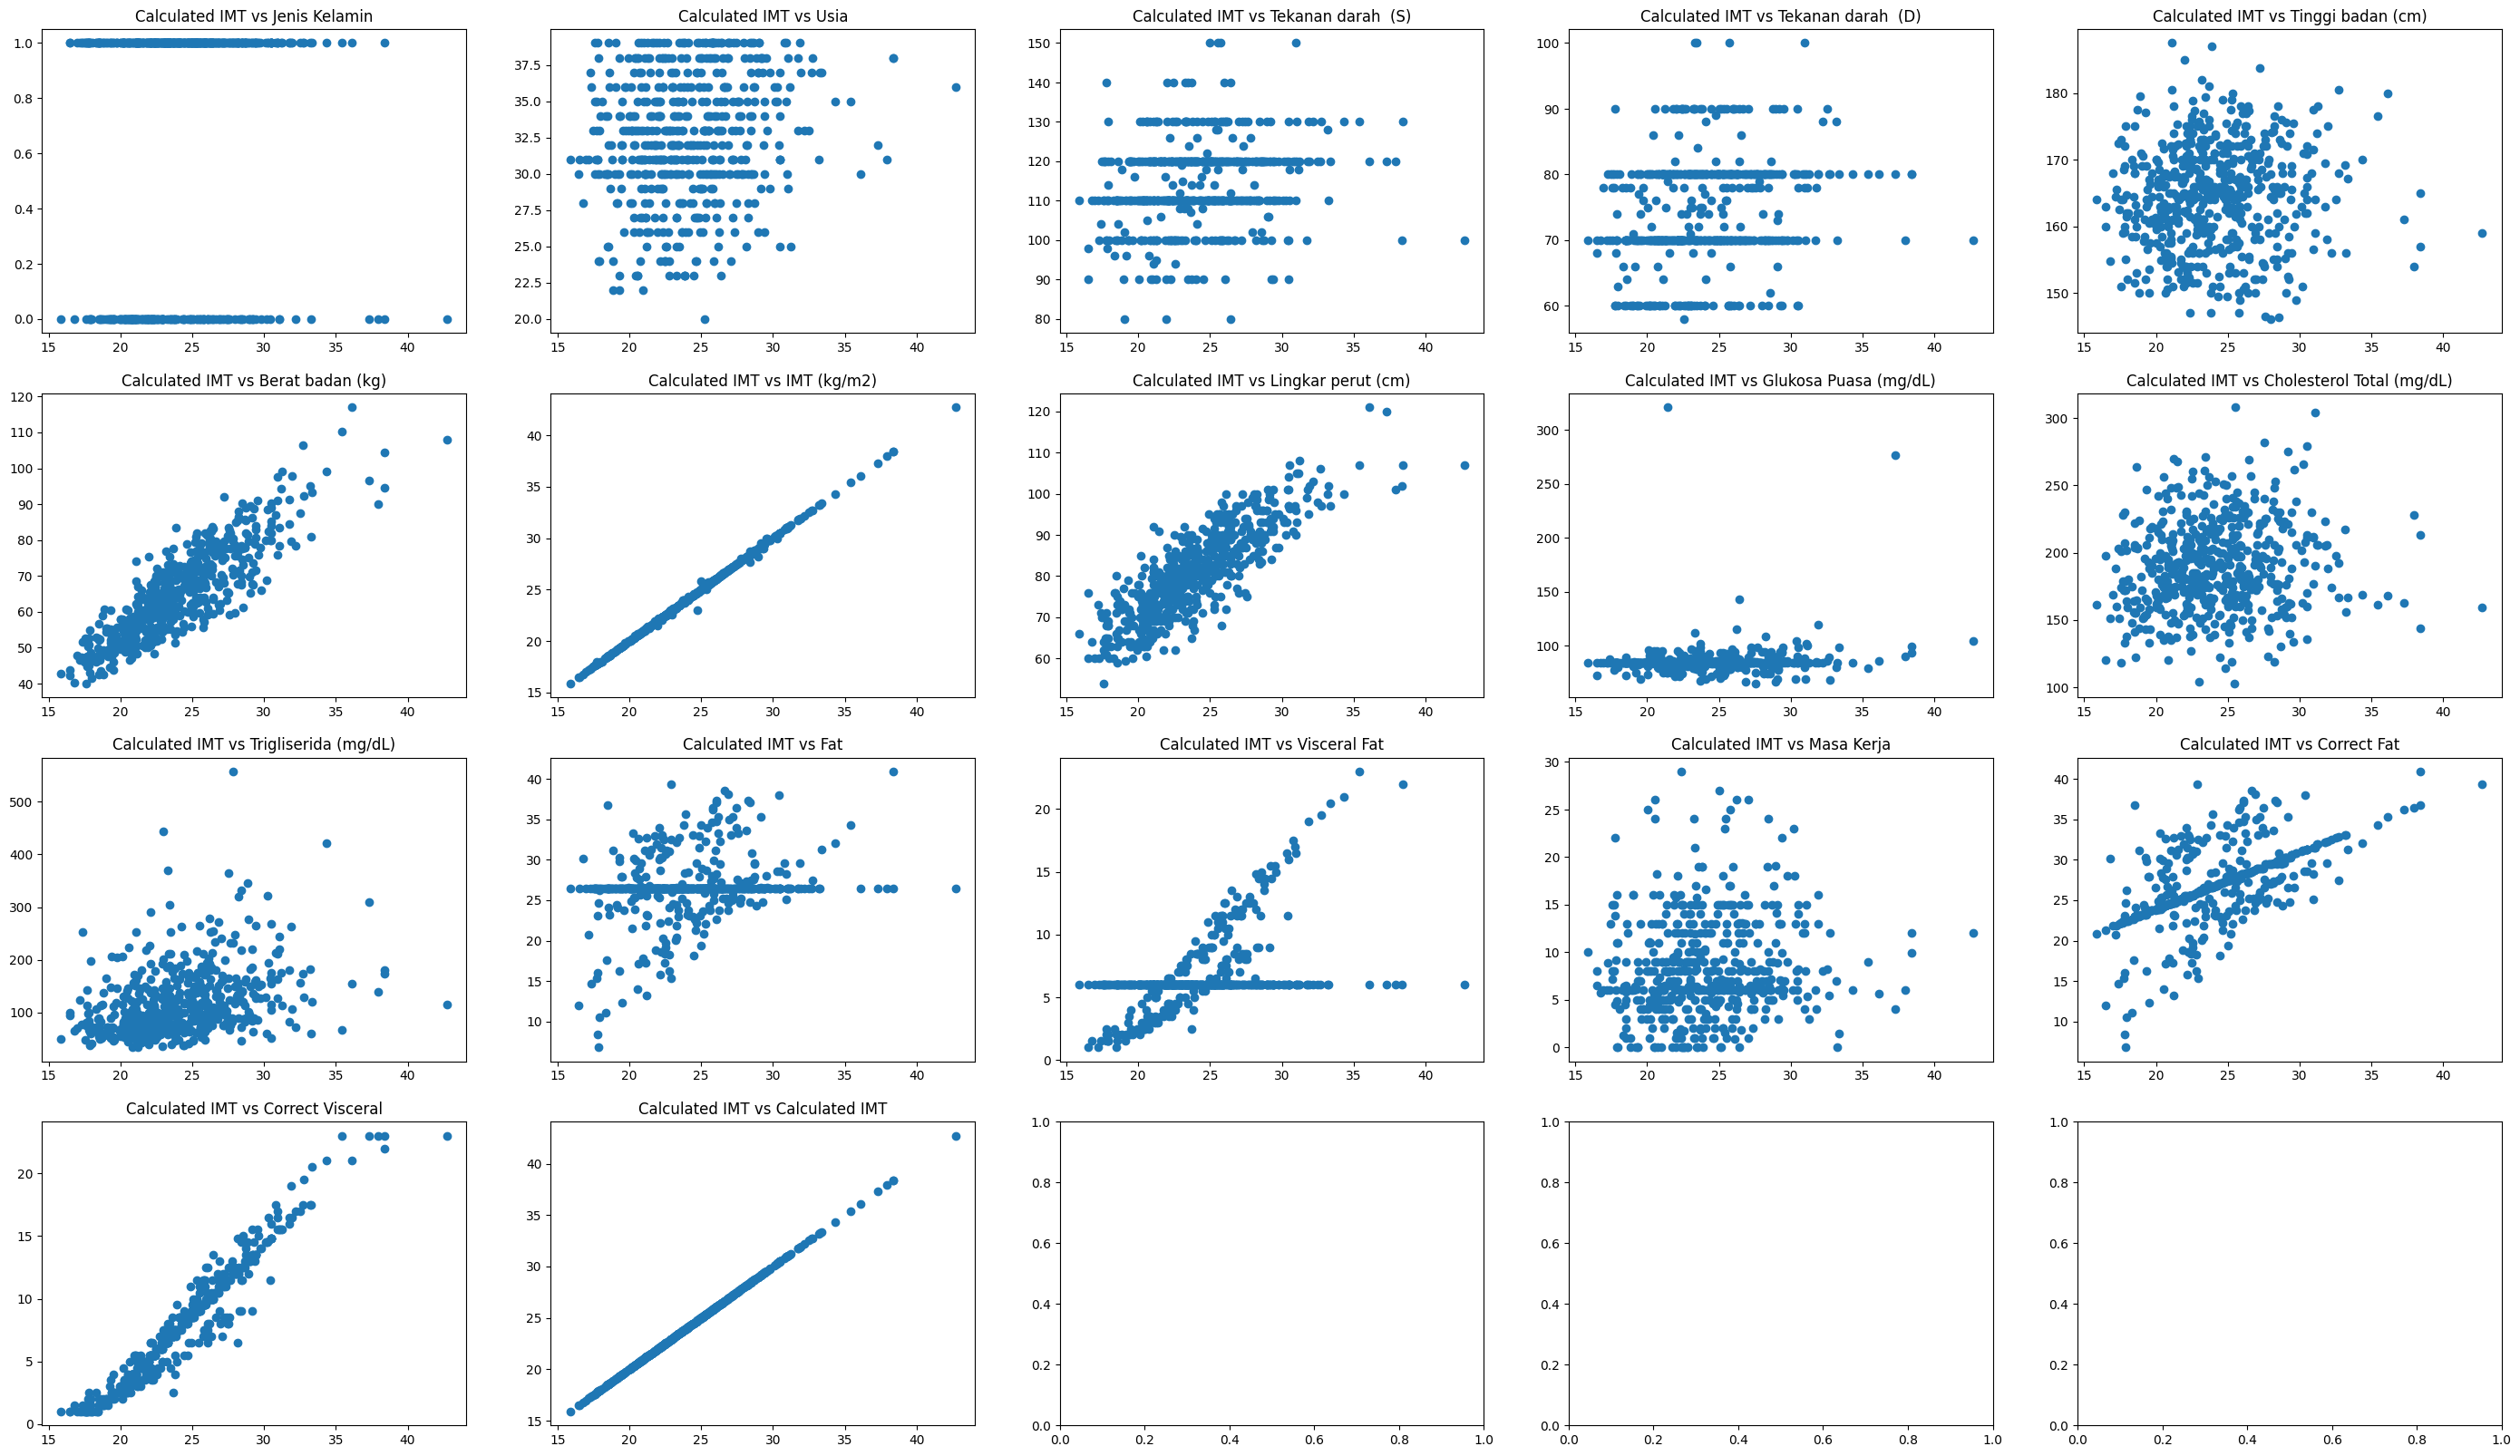

In [17]:
plotter(data, 'Calculated IMT')

In [18]:
def rounding(pred):
    unique_target = target.unique()
    rounded_value = []
    for x in pred:
        best = unique_target[0]
        for val in unique_target:
            if abs(val-x) < abs(best-x):
                best = val
        rounded_value.append(best)
    return np.array(rounded_value)

In [19]:
def perform_cross_validation(model, X, y, kf):
    # Initialize list to store RMSE scores for each fold
    rmse_scores = []

    # Perform k-fold cross-validation
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = rounding(model.predict(X_test))

        counter = y_pred - np.array(y_test)
        
        counter = len([elm for elm in counter if elm == 0])
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_scores.append(counter/len(y_test))
        # Append RMSE to the list of scores
        #rmse_scores.append(rmse)

    return rmse_scores

In [20]:
data = pd.read_csv('data.csv')

data2 = data[data['Cholesterol Total (mg/dL)'] != 187]

# encoding Jenis Kelamin if M = 1 and F = 0
data2["Jenis Kelamin"] = data2["Jenis Kelamin"].apply(lambda x: 1 if x == 'M' else 0)

# Target yang ingin diprediksi
target = data2['Cholesterol Total (mg/dL)']

# drop Tempat lahir
data2.drop(['Tempat lahir', 'Responden', 'Cholesterol Total (mg/dL)'], axis=1, inplace=True)

In [21]:
feat_selected = ['Jenis Kelamin', 'Usia', 'Tekanan darah  (S)', 'Tekanan darah  (D)',
       'Tinggi badan (cm)', 'Berat badan (kg)', 'Calculated IMT',
       'Lingkar perut (cm)', 'Glukosa Puasa (mg/dL)', 
       'Trigliserida (mg/dL)', 'Correct Fat',
       'Correct Visceral', 'Masa Kerja']